In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_hdf("./dataframe.h5")

In [3]:
def dataloader_energies(df):
    X = np.array([seq_to_onehot(row['Sequence']) for ind, row in df.iterrows()])
    Energies = np.array([row['E_Min'] for ind, row in df.iterrows()])
    return X, Energies

def seq_to_onehot(seq,N_max=12):
    seq = seq.ljust(N_max)
    encoding = np.zeros((N_max,3))
    for i,S in enumerate(seq):
        if S=='A':
            encoding[i,0] = 1.
        elif S=='B':
            encoding[i,1] = 1.
        elif S==' ':
            encoding[i,2] = 1.
    return encoding.flatten()

In [4]:
X, Y = dataloader_energies(df)
print(X.shape, Y.shape)

(4216, 36) (4216,)


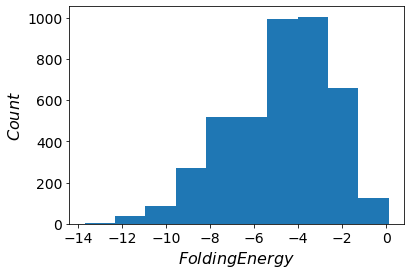

In [5]:
plt.hist(Y)
#formating
#plt.xlim([0.0,1.5])
#plt.ylim([0.0,2.0])
plt.xlabel('$Folding Energy$',fontsize=16)
plt.ylabel('$Count$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

#plt.savefig('tinyfold_energy_histogram.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)
plt.show()

In [14]:
def dataloader_rnn(df):
    sequences = []
    for ind, row in df.iterrows():
        if row['E_Min'] < -5.:
            sequences.append(row['Sequence'])
    return sequences


In [43]:
sequences = dataloader_rnn(df)
train_sequences = sequences
random.shuffle(train_sequences)
print(len(train_sequences))
train_sequences = train_sequences[:500]

1693


In [80]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,beta=1.0):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear( input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear( input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.beta = beta
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat(( input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(self.beta*output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [81]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingSequence():
    #category = randomChoice(all_categories)
    line = randomChoice(train_sequences)
    return line

In [82]:
all_letters = 'AB'
n_letters = len(all_letters) + 1

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [83]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    line = randomTrainingSequence()
    #category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor


In [84]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [85]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [86]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 10000#100000
print_every = 500#5000
plot_every = 50 #500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 1s (500 5%) 1.0050
0m 3s (1000 10%) 0.9377
0m 6s (1500 15%) 0.7995
0m 13s (2000 20%) 0.6153
0m 21s (2500 25%) 0.7199
0m 29s (3000 30%) 0.6989
0m 36s (3500 35%) 0.7172
0m 44s (4000 40%) 0.6760
0m 52s (4500 45%) 0.7427
0m 59s (5000 50%) 0.7510
1m 7s (5500 55%) 0.5921
1m 15s (6000 60%) 0.7729
1m 23s (6500 65%) 0.6982
1m 31s (7000 70%) 0.6428
1m 39s (7500 75%) 0.7452
1m 48s (8000 80%) 0.7291
1m 55s (8500 85%) 0.6228
2m 3s (9000 90%) 0.6861
2m 11s (9500 95%) 0.7479
2m 19s (10000 100%) 0.6176


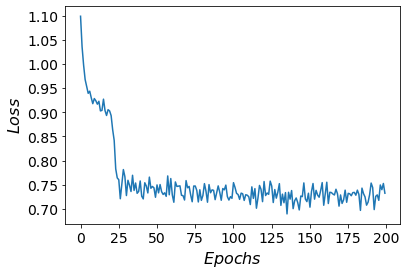

In [142]:
import matplotlib.pyplot as plt

#plt.figure()
plt.plot(all_losses)

#formating
#plt.ylim([1e-2,3])
#plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('learning_curve_RNN.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)
plt.show()

In [106]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A',beta=1.0):
    with torch.no_grad():  # no need to track history in sampling
        rnn.beta=beta
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            
            #topi = torch.multinomial(torch.exp(output),1)[0] 
            
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(start_letters='ABC',beta=1.0):
    samples_list = []
    for start_letter in start_letters:
        s = sample( start_letter,beta=1.0)
        print(s)
        samples_list.append(s)
    return samples_list

# Twenty samples starting with 'A'
samples_list = samples(762*'A'+100*'B')


AABAAABABAB
AAAAABABABB
AAABAABABAB
AAAAABABABB
AAAAABAABBB
AAABAAABABB
AAABAAABABB
AAAAABABABB
AAAAABABABB
AAAAABABABAB
AAAAABABABB
AAAAABABABB
AAAAABBABAB
AAAAABAAABB
AAAAABABABB
AAAAABABBAB
AAAAABABABBA
AAAAABAABBB
AAAAABABABB
AAAAABABBAB
AAAAABABABB
AAABAAABABB
AAABAAABABB
AAAAABABABB
AAAAABABABB
AABAABABBAB
AAAAABABABB
AAABAAABABB
AAAAABABABB
AAAAABABABB
AAAABABAABB
AAAAABABABB
AAAAABAABBB
AAAAABABABB
AAAAABABABB
AAABABABABAB
AAAABABABAB
AAAAABABABB
AAABAAAABBB
AAAAABABABB
AAAAAABBBAB
AAAAABABABB
AAAAABBABAB
AAAAABAABBB
AABAABABABAB
AAAAABABABA
AAAAAABBBAB
AAAAABBAABB
AABAAAAAABB
AAAABABABAB
AAAAABABABB
AAAAABABABB
AABAAAABBABA
AAABAAABABB
AAAAABABABB
AAAAABABABB
AAABAAABABB
AAAAABABABB
AAAAABABABAB
AAAABABABAB
AAAAABABABB
AAAAABABABB
AAAAABABABB
AAAAAABBBAB
AAAAABABABB
AAABABBAABAB
AAAAABABBAB
AAABAAABABB
AAAAABABABB
AAAAABBABAB
AAAABABABAB
AAAAABABABAB
AAAAABABABB
AAAAABABABB
AAAAABABABB
AAAAABABABB
AAAAABABABAB
AAAAABBAABB
AAAAABABABB
AAAAABABABB
AAAAABAABBB
AAAAABABABB
AAAAABA

In [131]:
unique_valid_seqs = []
unique_valid_es = []
unique_valid_ab = []

for seq in set(samples_list):
    try:
        print(seq,float(df.loc[df['Sequence'] == seq]['E_Min']),seq in train_sequences)
        e = float(df.loc[df['Sequence'] == seq]['E_Min'])
        ab = float(df.loc[df['Sequence'] == seq]['A/B_ratio'])

        unique_valid_seqs.append(seq) 
        unique_valid_es.append(e)
        unique_valid_ab.append(ab)
    except:
        print(f'{seq} is not in dataframe')

AAAAAABBBAB -6.04355470797268 True
AAABABABABB -5.80940350068626 False
AABAAAABBBBA -7.31594375567563 False
BAAAAABAABB -6.32346129134771 True
AAABABBAABAB -6.96845224848755 False
AAAABABABBB -5.22042899825405 False
AABABAAABBBB -5.39943866954697 False
BAAAAABBABA is not in dataframe
AAAAABAAABBB -7.75311146509293 True
AABAAAABBBB -4.74320264297246 False
BAAAAAABBBB -4.28966718509734 False
AABAABABABAB -8.36464547723718 False
AAABAAAABAB -8.33401821912753 False
AAAABABAABB -6.86705699290252 False
AAAAABABABBB -7.16045834782488 False
AAAAABBABABB -6.38915264376423 True
BABAAAABBBB -3.80448711918523 False
BAAABAABABB -5.26338181229449 True
AAAAABABABB -6.99101082263877 True
BAAAAABABBBA is not in dataframe
AAAABABBABAB -6.84034107410897 True
BAAAAABABAB -6.74343153158308 True
AAABAAABBBB -4.85288132604987 False
AAAABABBAAAB -7.58701175311917 True
AAAAAAABBBB -5.543375701742 False
BAAAABABABAB -7.20243316846758 False
AAAAABBABAB -6.40421893653733 False
AAABAAAABBAB -7.59217988366589 True


81


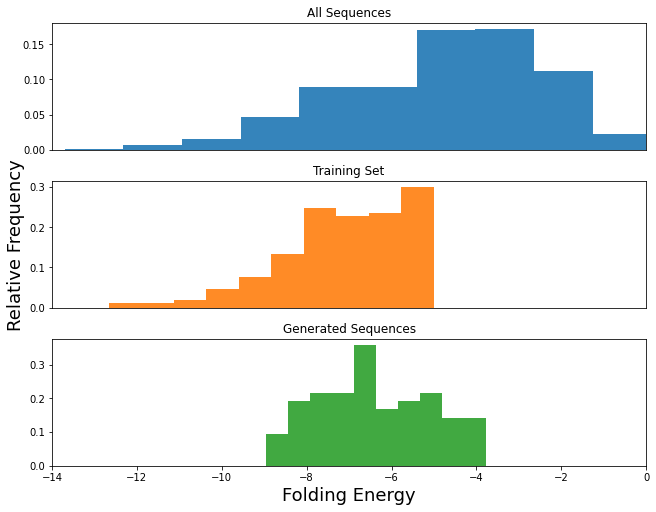

In [138]:
print(len(unique_valid_es))

fig = plt.figure(constrained_layout=True,figsize=(9,7))
axgrid = fig.subplot_mosaic([
    ['all'],
    ['train'],  
    ['gen']])

axgrid['all'].hist(Y,density=True,alpha=0.9,color='C0')
axgrid['all'].set_xlim([-14,0])
axgrid['all'].set_xticks([])
axgrid['all'].set_title('All Sequences')

#axgrid['all'].set_yticks([])

axgrid['train'].hist(training_set_e,density=True,alpha=0.9,color='C1')
axgrid['train'].set_xlim([-14,0])
axgrid['train'].set_xticks([])
axgrid['train'].set_title('Training Set')

#axgrid['train'].set_yticks([])

axgrid['train'].set_ylabel('Relative Frequency',fontsize=18)

axgrid['gen'].hist(unique_valid_es,density=True,alpha=0.9,color='C2')
axgrid['gen'].set_xlim([-14,0])
axgrid['gen'].set_xlabel('Folding Energy',fontsize=18)
axgrid['gen'].set_title('Generated Sequences')

#axgrid['gen'].set_yticks([])
plt.savefig('tinyfold_energy_histogram_rnn.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)
plt.show()


Text(0.5, 1.0, 'Generated Sequences')

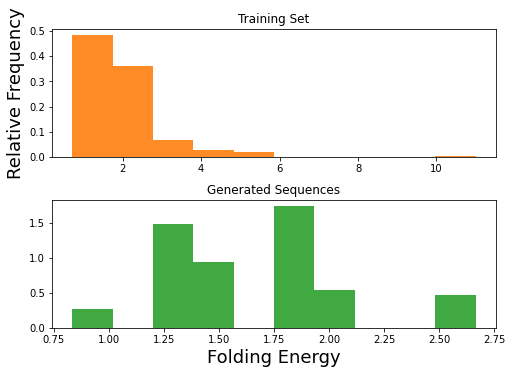

In [136]:
fig = plt.figure(constrained_layout=True,figsize=(7,5))
axgrid = fig.subplot_mosaic([
    #['all'],
    ['train'],  
    ['gen']])

#axgrid['all'].hist(Y,density=True,alpha=0.9,color='C0')
#axgrid['all'].set_xlim([-14,0])
#axgrid['all'].set_xticks([])
#axgrid['all'].set_title('All Sequences')

#axgrid['all'].set_yticks([])

axgrid['train'].hist(training_set_ab,density=True,alpha=0.9,color='C1')
#axgrid['train'].set_xlim([-14,0])
#axgrid['train'].set_xticks([])
axgrid['train'].set_title('Training Set')

#axgrid['train'].set_yticks([])

axgrid['train'].set_ylabel('Relative Frequency',fontsize=18)

axgrid['gen'].hist(unique_valid_ab,density=True,alpha=0.9,color='C2')
#axgrid['gen'].set_xlim([-14,0])
axgrid['gen'].set_xlabel('Folding Energy',fontsize=18)
axgrid['gen'].set_title('Generated Sequences')

#axgrid['gen'].set_yticks([])

In [135]:
# Training set statistics:
training_set_e = []
training_set_ab = []
count_A = 0
count_B = 0
for seq in train_sequences:
    if seq[0]=='A':
        count_A += 1
    elif seq[0]=='B':
        count_B += 1
    e = float(df.loc[df['Sequence'] == seq]['E_Min'])
    ab = float(df.loc[df['Sequence'] == seq]['A/B_ratio'])

    training_set_e.append(e)
    if ab < 1000:
        training_set_ab.append(ab)

print(f'start_A={count_A} start_B={count_B} {count_A/count_B}')

start_A=442 start_B=58 7.620689655172414


In [128]:
df

Sequence  N_Atoms  N_A  N_B     A/B_ratio  \
0              AAA        3    3    0  30000.000000   
1             AAAA        4    4    0  40000.000000   
2            AAAAA        5    5    0  50000.000000   
3           AAAAAA        6    6    0  60000.000000   
4          AAAAAAA        7    7    0  70000.000000   
...            ...      ...  ...  ...           ...   
4211  BBBBABBABBBB       12    2   10      0.199998   
4212  BBBBABBBBBBB       12    1   11      0.090908   
4213  BBBBBAABBBBB       12    2   10      0.199998   
4214  BBBBBABBBBBB       12    1   11      0.090908   
4215  BBBBBBBBBBBB       12    0   12      0.000000   

                                                Geo_Min     E_Min  \
0     [[1.55956, 0.282342, 0.0], [0.564823, 0.331952... -0.658850   
1     [[1.19959, -0.516883, 0.0], [0.757413, 0.37396... -1.683380   
2     [[0.989269, 0.367549, 0.0], [1.97629, 0.436397... -2.860871   
3     [[1.2959, 0.536921, 0.0], [2.28381, 0.490486, ... -4.055585   
4     [[2.23978, -0.798765, 0.0], [3.21304, -1.08181... -5.690167   
...                                                 ...       ...   
4211  [[5.86311, 0.028041, 0.0], [5.06732, -0.511699... -2.014420   
4212  [[4.72912, 1.99739, 0.0], [4.55687, 1.01783, 0... -2.604548   
4213  [[6.25371, 2.66538, 0.0], [5.80408, 1.77713, 0... -1.797604   
4214  [[4.78146, -1.69279, 0.0], [5.72068, -1.36311,... -2.609284   
4215  [[3.96655, 0.387772, 0.0], [4.76083, 0.981086,... -3.085966   

                                                 Angles  \
0                                   [68.96230819271678]   
1                [69.5483384404581, 119.16878596631516]   
2     [170.54780059909842, 69.36991879044658, 119.60...   
3     [179.90822236638977, 119.39284338451947, 69.46...   
4     [116.3797543045915, 67.86127131106488, 179.999...   
...                                                 ...   
4211  [176.7154489313745, 76.98791449221999, 162.261...   
4212  [174.2112772151853, 176.63644914156532, 165.29...   
4213  [179.61677622777728, 179.98072937734844, 177.6...   
4214  [171.39956992901884, 144.40456808740117, 136.2...   
4215  [179.50627736560108, 136.2389507624278, 133.10...   

                                             DistMatrix  \
0     [[0.0, 0.9959733185527613, 1.1277137258240675]...   
1     [[0.0, 0.9945522720445616, 1.129004190532967, ...   
2     [[0.0, 0.9894192749006865, 1.9721837869128729,...   
3     [[0.0, 0.9890006963217972, 1.9676942549095378,...   
4     [[0.0, 1.0135825075567355, 1.722936660624818, ...   
...                                                 ...   
4211  [[0.0, 0.9615617461713004, 1.9453121853782236,...   
4212  [[0.0, 0.994589290159511, 1.993036645572301, 2...   
4213  [[0.0, 0.9955677774014181, 1.987110316423323, ...   
4214  [[0.0, 0.9954009799070922, 1.9740031386287102,...   
4215  [[0.0, 0.9914142529719858, 1.9781643322646378,...   

                                          ConnectMatrix  
0                     [[0, 1, 1], [1, 0, 1], [1, 1, 0]]  
1     [[0, 1, 1, 1], [1, 0, 1, 0], [1, 1, 0, 1], [1,...  
2     [[0, 1, 0, 0, 1], [1, 0, 1, 1, 1], [0, 1, 0, 1...  
3     [[0, 1, 0, 0, 0, 1], [1, 0, 1, 0, 1, 1], [0, 1...  
4     [[0, 1, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0, 0],...  
...                                                 ...  
4211  [[0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0], [1, 0, ...  
4212  [[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, ...  
4213  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, ...  
4214  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0], [1, 0, ...  
4215  [[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0], [1, 0, ...  

[4216 rows x 10 columns]

In [139]:
print(set(samples_list))

{'AAAAAABBBAB', 'AAABABABABB', 'AABAAAABBBBA', 'BAAAAABAABB', 'AAABABBAABAB', 'AAAABABABBB', 'AABABAAABBBB', 'BAAAAABBABA', 'AAAAABAAABBB', 'AABAAAABBBB', 'BAAAAAABBBB', 'AABAABABABAB', 'AAABAAAABAB', 'AAAABABAABB', 'AAAAABABABBB', 'AAAAABBABABB', 'BABAAAABBBB', 'BAAABAABABB', 'AAAAABABABB', 'BAAAAABABBBA', 'AAAABABBABAB', 'BAAAAABABAB', 'AAABAAABBBB', 'AAAABABBAAAB', 'AAAAAAABBBB', 'BAAAABABABAB', 'AAAAABBABAB', 'AAABAAAABBAB', 'AAAAABABBBAB', 'AABABAAABAB', 'AAABAAABABB', 'BAAABAAABBB', 'BAAAAAABABB', 'BAAAAABABBBB', 'BAABAAABABB', 'AAAABABABAB', 'AAABAAABBAB', 'AABAAABABAB', 'AAAABBABABAB', 'BAAABBBAAAB', 'AAAAABBABABA', 'AABAAABAABB', 'AAABBABABAB', 'BAAAAABABBB', 'BAAABBBABAB', 'AAAAABABABAB', 'BABAAAABABB', 'BAAAABABBAB', 'AAAABAABABB', 'AAAAABABAAB', 'AAABAAAABBB', 'AAABAABABAB', 'AAAAABBBABABB', 'AAAAABABABBA', 'BAAAAABBBAB', 'AAAAABAABAB', 'AAAAABAABBBB', 'AAAAABBAABB', 'AAAAABAAABB', 'AABAAAAAABB', 'BAAAAABBABAB', 'AABAABABBAB', 'AAABBAAABAB', 'AAAABABABAAB', 'BAAAAABBABB', '